In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import auc, roc_curve, roc_auc_score
import random

from src.utils import evaluate, evaluate_out_sample, get_out_sample_predictions, train_standard
from src.model import CNN
from src.fseb import train_fseb
from src.adversarial import optimize_pixels

In [2]:
class ImageOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx][0]

In [3]:
batch_size = 128
context_batch_size = 128
num_samples = 1000

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
context_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
out_of_sample_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_mask = (train_dataset.targets == 0) | (train_dataset.targets == 1)
test_mask = (test_dataset.targets == 0) | (test_dataset.targets == 1)
context_mask = (train_dataset.targets >= 0) & (train_dataset.targets <= 5)
out_of_sample_mask = (test_dataset.targets >= 6) & (test_dataset.targets <= 9)

train_dataset.data = train_dataset.data[train_mask][:num_samples]
train_dataset.targets = train_dataset.targets[train_mask][:num_samples]

test_dataset.data = test_dataset.data[test_mask][:num_samples]
test_dataset.targets = test_dataset.targets[test_mask][:num_samples]

context_dataset.data = context_dataset.data[context_mask][:num_samples]
context_dataset.targets = context_dataset.targets[context_mask][:num_samples]
context_dataset = ImageOnlyDataset(context_dataset)

out_of_sample_dataset.data = out_of_sample_dataset.data[out_of_sample_mask][:num_samples]
out_of_sample_dataset.targets = out_of_sample_dataset.targets[out_of_sample_mask][:num_samples]

context_sampler = RandomSampler(context_dataset, num_samples=context_batch_size, replacement=False)
context_subset_loader = DataLoader(context_dataset, batch_size=context_batch_size, sampler=context_sampler)

input_dim = 28 * 28
output_dim = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
out_of_sample_loader = DataLoader(out_of_sample_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
model_standard = CNN(output_dim=2).to(device)
model_fseb = CNN(output_dim=2).to(device)

# Initialize prior model (randomly initialized and frozen)
prior_model = CNN(output_dim=2, prior=True).to(device)

# Define optimizers
optimizer_standard = optim.AdamW(model_standard.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer_fseb = optim.AdamW(model_fseb.parameters(), lr=1e-3, weight_decay=1e-4)

# Train models
num_epochs = 10
progress_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")

for epoch in progress_bar:
    # Train standard model
    model_standard = train_standard(model_standard, train_loader, optimizer_standard, device)
    
    # Train FS-EB model
    model_fseb = train_fseb(model_fseb, prior_model, train_loader, context_subset_loader, 
                            optimizer_fseb, device, tau_f=.1, tau_theta=1e-4, context_batch_size=context_batch_size)
    
    standard_acc = evaluate(model_standard, test_loader, device)
    fseb_acc = evaluate(model_fseb, test_loader, device)

    standard_out_acc = evaluate_out_sample(model_standard, out_of_sample_loader, device)
    fseb_out_acc = evaluate_out_sample(model_fseb, out_of_sample_loader, device)

    standard_in_acc = evaluate_out_sample(model_standard, test_loader, device)
    fseb_in_acc = evaluate_out_sample(model_fseb, test_loader, device)
    
    progress_bar.set_postfix({
        "Standard Acc": f"{standard_acc:.2f}%",
        "FS-EB Acc": f"{fseb_acc:.2f}%",
        "Standard In / Out Of Sample Value": f"{standard_in_acc:.2f} / {standard_out_acc:.2f}",
        "FS-EB In / Out Of Sample Value": f"{fseb_in_acc:.2f} / {fseb_out_acc:.2f}",
    })

Training Progress: 100%|██████████| 10/10 [03:09<00:00, 18.97s/epoch, Standard Acc=99.90%, FS-EB Acc=99.90%, Standard In / Out Of Sample Value=1.00 / 0.93, FS-EB In / Out Of Sample Value=0.94 / 0.67] 


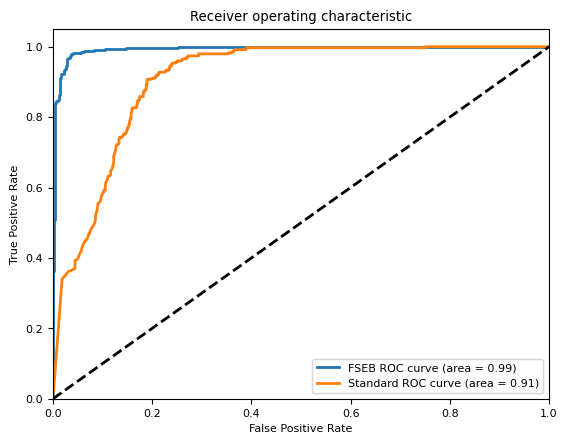

In [5]:
ood_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
ood_data.data = ood_data.data[test_mask | out_of_sample_mask][:num_samples]
ood_data.targets = ood_data.targets[test_mask | out_of_sample_mask][:num_samples]
std_mask = (ood_data.targets == 0) | (ood_data.targets == 1)
ood_mask = (ood_data.targets >= 6) & (ood_data.targets <= 9)
ood_data.targets[std_mask] = 0
ood_data.targets[ood_mask] = 1
ood_loader = torch.utils.data.DataLoader(ood_data, batch_size=batch_size, shuffle=True)

pred_fseb, labels_fseb = get_out_sample_predictions(model_fseb, ood_loader, device)
pred_std, labels_std = get_out_sample_predictions(model_standard, ood_loader, device)

plt.figure()
fpr, tpr, _ = roc_curve(labels_fseb, pred_fseb)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='FSEB ROC curve (area = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(labels_std, pred_std)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Standard ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


100%|██████████| 200/200 [00:00<00:00, 728.19it/s]


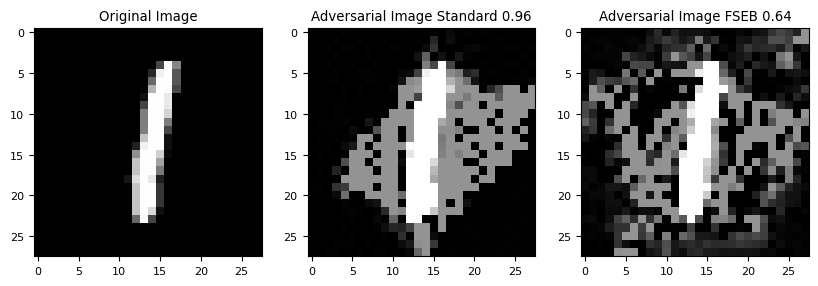

In [6]:
alpha = 2/255
num_steps = 200
img, target = test_dataset[random.randint(0, len(test_dataset)-1)]
img = img.unsqueeze(0)
target = 1 - target

adv_image_standard, probs_target_standard = optimize_pixels(model_standard, img, target_label=target, device=device, alpha=alpha, num_steps=num_steps)
adv_image_fseb, probs_target_fseb = optimize_pixels(model_fseb, img, target_label=target, device=device, alpha=alpha, num_steps=num_steps)

img = img.squeeze(0)
img = img.permute(1, 2, 0)
adv_image_standard = adv_image_standard.squeeze(0)
adv_image_standard = adv_image_standard.permute(1, 2, 0)

adv_image_fseb = adv_image_fseb.squeeze(0)
adv_image_fseb = adv_image_fseb.permute(1, 2, 0)

# plot images with subplot
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(adv_image_standard, cmap='gray')
ax[1].set_title(f'Adversarial Image Standard {probs_target_standard[-1]:.2f}')
ax[2].imshow(adv_image_fseb, cmap='gray')
ax[2].set_title(f'Adversarial Image FSEB {probs_target_fseb[-1]:.2f}')
plt.show()

In [7]:
test_dataset_adv_standard = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset_adv_fseb = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_dataset_adv_standard.data = test_dataset_adv_standard.data[test_mask][:num_samples]
test_dataset_adv_standard.targets = test_dataset_adv_standard.targets[test_mask][:num_samples]
test_dataset_adv_fseb.data = test_dataset_adv_fseb.data[test_mask][:num_samples]
test_dataset_adv_fseb.targets = test_dataset_adv_fseb.targets[test_mask][:num_samples]

preds_standard = []
preds_fseb = []
for idx, ((image_standard, label_standard), (image_fseb, label_fseb)) in tqdm(enumerate(zip(test_dataset_adv_standard, test_dataset_adv_fseb)), total=len(test_dataset_adv_standard)):
    adv_image_standard, probs_target_standard = optimize_pixels(model_standard, image_standard.unsqueeze(0).to(device), target_label=1-label_standard, device=device, alpha=alpha, num_steps=num_steps, disable_tqdm=True)
    adv_image_fseb, probs_target_fseb = optimize_pixels(model_fseb, image_fseb.unsqueeze(0).to(device), target_label=1-label_fseb, device=device, alpha=alpha, num_steps=num_steps, disable_tqdm=True)
    test_dataset_adv_standard.data[idx] = (adv_image_standard.squeeze(0) * 255).byte()
    test_dataset_adv_fseb.data[idx] = (adv_image_fseb.squeeze(0) * 255).byte()
    preds_standard.append(probs_target_standard[-1])
    preds_fseb.append(probs_target_fseb[-1])

100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]


In [8]:
# adv_vs_normal_dataset_standard = torch.utils.data.ConcatDataset([test_dataset_adv_standard, test_dataset])
adv_vs_normal_dataset_standard_labels = torch.cat([torch.ones(len(test_dataset_adv_standard)), torch.zeros(len(test_dataset))], dim=0).to(device)

# adv_vs_normal_dataset_fseb = torch.utils.data.ConcatDataset([test_dataset_adv_fseb, test_dataset])
adv_vs_normal_dataset_fseb_labels = torch.cat([torch.ones(len(test_dataset_adv_fseb)), torch.zeros(len(test_dataset))], dim=0).to(device)

for (x, l) in test_dataset:
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model_standard(x)
    probits = torch.softmax(pred, dim=-1).squeeze(0)
    preds_standard.append(probits[l])

for (x, l) in test_dataset:
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model_fseb(x)
    probits = torch.softmax(pred, dim=-1).squeeze(0)
    preds_fseb.append(probits[l])

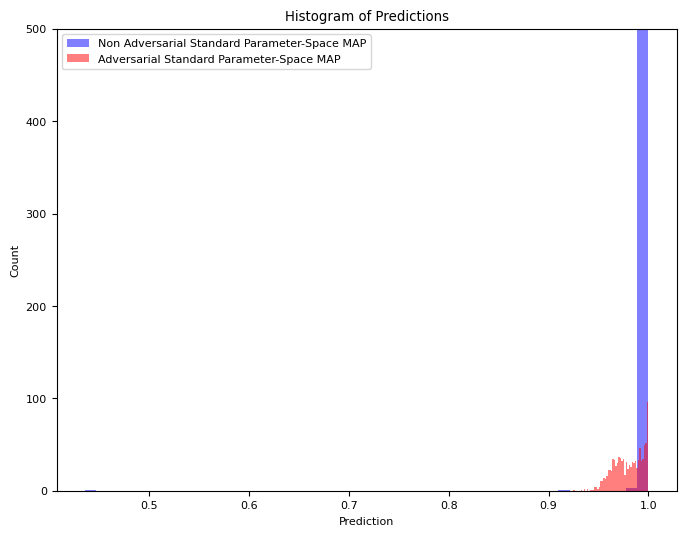

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(preds_standard[len(test_dataset_adv_standard):], bins=50, alpha=0.5, label="Non Adversarial Standard Parameter-Space MAP", color='blue')
plt.hist(preds_standard[:len(test_dataset_adv_standard)], bins=50, alpha=0.5, label="Adversarial Standard Parameter-Space MAP", color='red')
plt.legend()
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.ylim(0, 500)
plt.title("Histogram of Predictions")
plt.show()

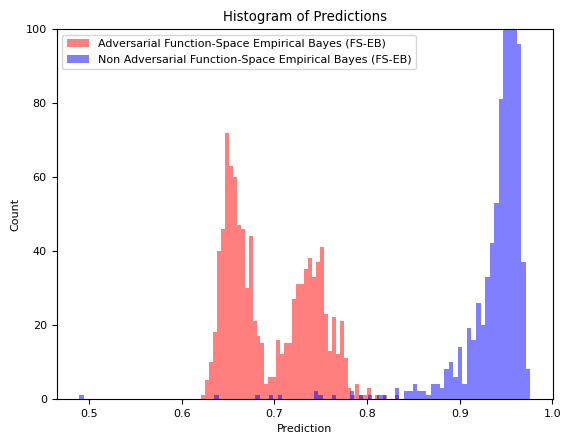

In [10]:
plt.hist(preds_fseb[:len(test_dataset_adv_standard)], bins=50, alpha=0.5, label="Adversarial Function-Space Empirical Bayes (FS-EB)", color='red')
plt.hist(preds_fseb[len(test_dataset_adv_standard):], bins=100, alpha=0.5, label="Non Adversarial Function-Space Empirical Bayes (FS-EB)", color='blue')
plt.legend()
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.ylim(0, 100)
plt.title("Histogram of Predictions")
plt.show()